In [1]:
# General
import numpy as np
import pandas as pd
import os
import jumpmodels.utils

# For loading data and feature engineering
from feature_25 import DataLoader, MergedDataLoader

# For data prep and pre-processing
from jumpmodels.utils import filter_date_range 
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd 

# For model fit and prediction
from joblib import Parallel, delayed # allows parallel grid search on all 4 cores
from jumpmodels.sparse_jump import SparseJumpModel

# For plotting
from jumpmodels.plot import plot_regimes_and_cumret, plot_cumret
import matplotlib.pyplot as plt

In [2]:
import importlib
import feature_25 
importlib.reload(feature_25)


<module 'feature_25' from 'c:\\Users\\victo\\0_thesis_repo\\thesis_vri_vp\\victor\\feature_25.py'>

In [3]:
# Import data
# -------------------------

# Define file path
directory = r"C:\Users\victo\0_thesis_repo\thesis_vri_vp\data"
factor_file = os.path.join(directory, "factor_data.csv")
market_file = os.path.join(directory, "market_data.csv")

# Use DataLoader to generate features when we use factor and market data
data = MergedDataLoader(
    factor_file=factor_file,
    market_file=market_file,
    ver="v2",
    factor_col="VLUE"  # specify which column in factor_data.csv is your factor return
).load(start_date="2002-05-31", end_date="2025-02-24")

# Ensure all attributes have the same index before filtering
common_index = data.X.index.intersection(data.ret_ser.index).intersection(data.market_ser.index)
data.X = data.X.loc[common_index]
data.ret_ser = data.ret_ser.loc[common_index]
data.market_ser = data.market_ser.loc[common_index]

# Identify and drop dates where returns are exactly 0.0
zero_return_dates = data.ret_ser[data.ret_ser == 0.0].index

# Drop from all attributes to maintain alignment
data.X = data.X.drop(zero_return_dates, errors='ignore')
data.ret_ser = data.ret_ser.drop(zero_return_dates, errors='ignore')
data.market_ser = data.market_ser.drop(zero_return_dates, errors='ignore')  # Ensure market returns match


# print("Daily returns:", data.ret_ser)
# print("Engineered features:", data.X)

# factor_data = pd.read_csv(factor_file, parse_dates=["Date"], index_col="Date")

# Plot cumulative returns
# plot_cumret(factor_data["IWF"])
# plt.show()


In [4]:
# Train/test split
# -------------------------

train_start, test_start = "2002-05-31", "2022-01-01" #actual start date of training will be in August due to 63 trading days required for EWMA
# filter dates
X_train = filter_date_range(data.X, start_date=train_start, end_date=test_start)
X_test = filter_date_range(data.X, start_date=test_start)
# print time split
train_start, train_end = X_train.index[[0, -1]]
test_start, test_end = X_test.index[[0, -1]]
print("Training starts at:", train_start, "and ends at:", train_end)
print("Testing starts at:", test_start, "and ends at:", test_end)

# Preprocessing
# -------------------------

# Clip the data within 3 standard deviations to mitigate the impact of outliers and standardize the clipped data (zero mean and unit variance)
clipper = DataClipperStd(mul=3.)
scalar = StandardScalerPD()
# fit on training data
X_train_processed = scalar.fit_transform(clipper.fit_transform(X_train))
# transform the test data
X_test_processed = scalar.transform(clipper.transform(X_test))

Training starts at: 2002-08-28 00:00:00 and ends at: 2021-12-31 00:00:00
Testing starts at: 2022-01-03 00:00:00 and ends at: 2025-02-24 00:00:00


In [ ]:
def rolling_window_cv_sjm_long_short(
    lam, kappa, 
    X, 
    factor_returns, 
    market_returns, 
    n_splits=5, 
    min_train_size=5*252,
    cost_per_100pct=0.0005,  # 5 bps cost per 100% turnover
    annual_threshold=0.05    # ±5% annual threshold
):
    """
    Perform rolling expanding-window cross-validation using a
    long–short strategy evaluation as described in Shu et al. (2025).

    Parameters
    ----------
    lam : float
        The jump penalty parameter (lambda).
    kappa : float
        The sqrt of max features (kappa). The model will use int(kappa^2) features.
    X : pd.DataFrame
        Feature matrix (indexed by date).
    factor_returns : pd.Series
        Daily returns for the factor (indexed by date).
    market_returns : pd.Series
        Daily returns for the corresponding market or benchmark (indexed by date).
    n_splits : int, optional
        Number of cross-validation folds (default is 5).
    min_train_size : int, optional
        Minimum number of samples in the training set (default is ~5 years).
    cost_per_100pct : float, optional
        Transaction cost for a 100% position turnover (default is 5 bps).
    annual_threshold : float, optional
        Threshold (±5%) in annualized expected returns for deciding full long/short.

    Returns
    -------
    float
        The average Sharpe ratio across all cross-validation folds
        for the hypothetical long–short strategy.
    """
    # Compute the split size for rolling expanding-window cross-validation
    split_size = (len(X) - min_train_size) // n_splits

    # Compute the number of maximum features based on kappa
    max_feats = int(kappa**2)

    # List to store Sharpe ratios for each validation fold
    sharpe_scores = []

    # Helper function to determine position based on expected annualized return
    def position_from_expected_return(ann_ret, threshold=annual_threshold):
        """
        Maps the expected annualized active return to a position in [-1, 1].
        If ann_ret > threshold, fully long = +1.
        If ann_ret < -threshold, fully short = -1.
        Else linearly scale between -1 and +1.
        """
        if ann_ret > threshold:
            return 1.0
        elif ann_ret < -threshold:
            return -1.0
        else:
            return ann_ret / threshold  # Scale linearly between -1 and +1

    # Loop over cross-validation splits
    for i in range(n_splits):
        # Define training and validation split
        train_end = min_train_size + i * split_size
        X_train_cv = X.iloc[:train_end]  # selects the first train_end rows from X and y, creating a training dataset.
        X_val_cv   = X.iloc[train_end:]  # selectes the rows after train_end and forward to be used for out of sample validation

        y_train_cv = factor_returns.iloc[:train_end]  # Training factor returns
        y_val_cv   = factor_returns.iloc[train_end:]  # Validation factor returns

        m_train_cv = market_returns.iloc[:train_end]  # Training market returns
        m_val_cv   = market_returns.iloc[train_end:]  # Validation market returns

        # Fit Sparse Jump Model (SJM) on training data
        model = SparseJumpModel(
            n_components=2,  # Model assumes two regimes
            max_feats=max_feats,  # Limit number of features
            jump_penalty=lam,  # Regularization parameter for jumps
            cont=False,  # Discrete jump model
            max_iter=30  # Maximum iterations for fitting
        )
        model.fit(X_train_cv, y_train_cv, sort_by="cumret")  # Fit model using cumulative returns as sorting criterion

        # Get in-sample regime predictions for training data
        train_states = model.predict(X_train_cv)

        # Compute daily active returns in training set (factor return minus market return)
        train_active_ret = y_train_cv - m_train_cv

        # Compute expected annualized return for each state
        unique_states = np.unique(train_states)
        state_to_expected = {}
        for st in unique_states:
            mask_st = (train_states == st)  # Identify samples in the state
            if mask_st.sum() > 0:
                avg_daily = train_active_ret[mask_st].mean()  # Average daily return for the state
                ann_ret = avg_daily * 252.0  # Annualized return
            else:
                ann_ret = 0.0  # Default to zero if state is empty
            state_to_expected[st] = ann_ret  # Store expected return for state

        # Predict states in validation set
        val_states = model.predict(X_val_cv)

        # Compute strategy performance in validation set
        val_active_ret = y_val_cv - m_val_cv  # Compute active return in validation
        val_positions = np.zeros(len(val_states))  # Store factor exposure in [-1, 1]
        strategy_ret = np.zeros(len(val_states))  # Track daily returns (net of costs)

        prev_position = 0.0  # Initialize previous position for turnover calculation

        for t in range(len(val_states)):
            st = val_states[t]  # Get predicted state for the day
            exp_ann_ret = state_to_expected.get(st, 0.0)  # Get expected return for state
            position = position_from_expected_return(exp_ann_ret, annual_threshold)  # Determine position

            # Compute daily turnover cost
            turnover = abs(position - prev_position) * 2.0  # Turnover is doubled for long/short trades
            cost = turnover * cost_per_100pct  # Multiply by cost per 100% turnover

            # Compute daily profit and loss (PnL) net of transaction cost
            daily_pnl = position * val_active_ret.iloc[t]  # Daily PnL from active return
            daily_net = daily_pnl - cost  # Subtract transaction costs

            strategy_ret[t] = daily_net  # Store net return
            prev_position = position  # Update previous position

        # Compute Sharpe ratio for the validation period
        avg_ret = np.mean(strategy_ret)  # Mean daily return
        std_ret = np.std(strategy_ret, ddof=1)  # Standard deviation of daily returns
        if std_ret == 0:
            val_sharpe = 0.0  # Avoid division by zero
        else:
            val_sharpe = (avg_ret / std_ret) * np.sqrt(252.0)  # Annualized Sharpe ratio

        sharpe_scores.append(val_sharpe)  # Store Sharpe ratio for this fold

    return np.mean(sharpe_scores)  # Return average Sharpe ratio across folds

# Example usage in parallel cross-validation:
lambda_values = np.logspace(0.5, 2, 5)  # Generate λ values from 1 to 100
kappa_values  = np.linspace(1, np.sqrt(X_train_processed.shape[1]), 5)  # Generate κ values


# Assign market return series
market_ser = data.market_ser  # Ensure market returns are aligned with factor returns

# Perform cross-validation in parallel using joblib
results = Parallel(n_jobs=4)(
    delayed(rolling_window_cv_sjm_long_short)(
        lam, kappa, 
        X_train_processed, 
        factor_returns=data.ret_ser, 
        market_returns=market_ser
    )
    for lam in lambda_values  # Iterate over lambda values
    for kappa in kappa_values  # Iterate over kappa values
)

# Identify the best lambda and kappa combination
best_index = np.argmax(results)  # Find index of max Sharpe ratio
best_lambda = lambda_values[best_index // len(kappa_values)]  # Extract corresponding lambda
best_kappa = kappa_values[best_index % len(kappa_values)]  # Extract corresponding kappa
max_feats_best = int(best_kappa**2)  # Compute best max features

# Print optimal hyperparameters
print(f"Best Jump Penalty (λ): {best_lambda}")
print(f"Best Max Features (κ²): {max_feats_best}")


KeyError: "[Timestamp('2007-03-29 00:00:00'), Timestamp('2007-03-30 00:00:00'), Timestamp('2007-04-02 00:00:00'), Timestamp('2007-04-03 00:00:00'), Timestamp('2007-04-04 00:00:00'), Timestamp('2007-04-05 00:00:00'), Timestamp('2007-04-09 00:00:00'), Timestamp('2007-04-10 00:00:00'), Timestamp('2007-04-11 00:00:00'), Timestamp('2007-04-12 00:00:00'), Timestamp('2007-04-13 00:00:00'), Timestamp('2007-04-16 00:00:00'), Timestamp('2007-04-17 00:00:00'), Timestamp('2007-04-18 00:00:00'), Timestamp('2007-04-19 00:00:00'), Timestamp('2007-04-20 00:00:00'), Timestamp('2007-04-23 00:00:00'), Timestamp('2007-04-24 00:00:00'), Timestamp('2007-04-25 00:00:00'), Timestamp('2007-04-26 00:00:00'), Timestamp('2007-04-27 00:00:00'), Timestamp('2007-04-30 00:00:00'), Timestamp('2007-05-01 00:00:00'), Timestamp('2007-05-02 00:00:00'), Timestamp('2007-05-03 00:00:00'), Timestamp('2007-05-04 00:00:00'), Timestamp('2007-05-07 00:00:00'), Timestamp('2007-05-08 00:00:00'), Timestamp('2007-05-09 00:00:00'), Timestamp('2007-05-10 00:00:00'), Timestamp('2007-05-11 00:00:00'), Timestamp('2007-05-14 00:00:00'), Timestamp('2007-05-15 00:00:00'), Timestamp('2007-05-16 00:00:00'), Timestamp('2007-05-17 00:00:00'), Timestamp('2007-05-18 00:00:00'), Timestamp('2007-05-21 00:00:00'), Timestamp('2007-05-22 00:00:00'), Timestamp('2007-05-23 00:00:00'), Timestamp('2007-05-24 00:00:00'), Timestamp('2007-05-25 00:00:00'), Timestamp('2007-05-29 00:00:00'), Timestamp('2007-05-30 00:00:00'), Timestamp('2007-05-31 00:00:00'), Timestamp('2007-06-01 00:00:00'), Timestamp('2007-06-04 00:00:00'), Timestamp('2007-06-05 00:00:00'), Timestamp('2007-06-06 00:00:00'), Timestamp('2007-06-07 00:00:00'), Timestamp('2007-06-08 00:00:00'), Timestamp('2007-06-11 00:00:00'), Timestamp('2007-06-12 00:00:00'), Timestamp('2007-06-13 00:00:00'), Timestamp('2007-06-14 00:00:00'), Timestamp('2007-06-15 00:00:00'), Timestamp('2007-06-18 00:00:00'), Timestamp('2007-06-19 00:00:00'), Timestamp('2007-06-20 00:00:00'), Timestamp('2007-06-21 00:00:00'), Timestamp('2007-06-22 00:00:00'), Timestamp('2007-06-25 00:00:00'), Timestamp('2007-06-26 00:00:00'), Timestamp('2007-06-27 00:00:00'), Timestamp('2007-06-28 00:00:00'), Timestamp('2007-06-29 00:00:00'), Timestamp('2007-07-02 00:00:00'), Timestamp('2007-07-03 00:00:00'), Timestamp('2007-07-05 00:00:00'), Timestamp('2007-07-06 00:00:00'), Timestamp('2007-07-09 00:00:00'), Timestamp('2007-07-10 00:00:00'), Timestamp('2007-07-11 00:00:00'), Timestamp('2007-07-12 00:00:00'), Timestamp('2007-07-13 00:00:00'), Timestamp('2007-07-16 00:00:00'), Timestamp('2007-07-17 00:00:00'), Timestamp('2007-07-18 00:00:00'), Timestamp('2007-07-19 00:00:00'), Timestamp('2007-07-20 00:00:00'), Timestamp('2007-07-23 00:00:00'), Timestamp('2007-07-24 00:00:00'), Timestamp('2007-07-25 00:00:00'), Timestamp('2007-07-26 00:00:00'), Timestamp('2007-07-27 00:00:00'), Timestamp('2007-07-30 00:00:00'), Timestamp('2007-07-31 00:00:00'), Timestamp('2007-08-01 00:00:00'), Timestamp('2007-08-02 00:00:00'), Timestamp('2007-08-03 00:00:00'), Timestamp('2007-08-06 00:00:00'), Timestamp('2007-08-07 00:00:00'), Timestamp('2007-08-08 00:00:00'), Timestamp('2007-08-09 00:00:00'), Timestamp('2007-08-10 00:00:00'), Timestamp('2007-08-13 00:00:00'), Timestamp('2007-08-14 00:00:00'), Timestamp('2007-08-15 00:00:00'), Timestamp('2007-08-16 00:00:00'), Timestamp('2007-08-17 00:00:00'), Timestamp('2007-08-20 00:00:00'), Timestamp('2007-08-21 00:00:00'), Timestamp('2007-08-22 00:00:00'), Timestamp('2007-08-23 00:00:00'), Timestamp('2007-08-24 00:00:00'), Timestamp('2007-08-27 00:00:00'), Timestamp('2007-08-28 00:00:00'), Timestamp('2007-08-29 00:00:00'), Timestamp('2007-08-30 00:00:00'), Timestamp('2007-08-31 00:00:00'), Timestamp('2007-09-04 00:00:00'), Timestamp('2007-09-05 00:00:00'), Timestamp('2007-09-06 00:00:00'), Timestamp('2007-09-07 00:00:00'), Timestamp('2007-09-10 00:00:00'), Timestamp('2007-09-11 00:00:00'), Timestamp('2007-09-12 00:00:00'), Timestamp('2007-09-13 00:00:00'), Timestamp('2007-09-14 00:00:00'), Timestamp('2007-09-17 00:00:00'), Timestamp('2007-09-18 00:00:00'), Timestamp('2007-09-19 00:00:00'), Timestamp('2007-09-20 00:00:00'), Timestamp('2007-09-21 00:00:00'), Timestamp('2007-09-24 00:00:00'), Timestamp('2007-09-25 00:00:00'), Timestamp('2007-09-26 00:00:00'), Timestamp('2007-09-27 00:00:00'), Timestamp('2007-09-28 00:00:00'), Timestamp('2007-10-01 00:00:00'), Timestamp('2007-10-02 00:00:00'), Timestamp('2007-10-03 00:00:00'), Timestamp('2007-10-04 00:00:00'), Timestamp('2007-10-05 00:00:00'), Timestamp('2007-11-06 00:00:00'), Timestamp('2007-11-07 00:00:00'), Timestamp('2007-11-08 00:00:00'), Timestamp('2007-11-09 00:00:00'), Timestamp('2007-12-12 00:00:00'), Timestamp('2007-12-13 00:00:00'), Timestamp('2007-12-14 00:00:00'), Timestamp('2007-12-17 00:00:00'), Timestamp('2007-12-18 00:00:00'), Timestamp('2007-12-19 00:00:00'), Timestamp('2007-12-20 00:00:00'), Timestamp('2007-12-21 00:00:00'), Timestamp('2007-12-24 00:00:00'), Timestamp('2007-12-26 00:00:00'), Timestamp('2007-12-27 00:00:00'), Timestamp('2007-12-28 00:00:00'), Timestamp('2007-12-31 00:00:00'), Timestamp('2008-01-02 00:00:00'), Timestamp('2008-01-03 00:00:00'), Timestamp('2008-01-04 00:00:00'), Timestamp('2008-01-07 00:00:00'), Timestamp('2008-01-08 00:00:00'), Timestamp('2008-01-09 00:00:00'), Timestamp('2008-01-10 00:00:00'), Timestamp('2008-01-11 00:00:00'), Timestamp('2008-01-14 00:00:00'), Timestamp('2008-01-15 00:00:00'), Timestamp('2008-01-16 00:00:00'), Timestamp('2008-01-17 00:00:00'), Timestamp('2008-01-18 00:00:00'), Timestamp('2008-01-22 00:00:00'), Timestamp('2008-01-23 00:00:00'), Timestamp('2008-01-24 00:00:00'), Timestamp('2008-01-25 00:00:00'), Timestamp('2008-01-28 00:00:00'), Timestamp('2008-01-29 00:00:00'), Timestamp('2008-01-30 00:00:00'), Timestamp('2008-01-31 00:00:00'), Timestamp('2008-02-01 00:00:00'), Timestamp('2008-02-04 00:00:00'), Timestamp('2008-02-05 00:00:00'), Timestamp('2008-02-06 00:00:00'), Timestamp('2008-02-07 00:00:00'), Timestamp('2008-02-08 00:00:00'), Timestamp('2008-02-11 00:00:00'), Timestamp('2008-02-12 00:00:00'), Timestamp('2008-02-13 00:00:00'), Timestamp('2008-02-14 00:00:00'), Timestamp('2008-02-15 00:00:00'), Timestamp('2008-02-19 00:00:00'), Timestamp('2008-02-20 00:00:00'), Timestamp('2008-02-21 00:00:00'), Timestamp('2008-02-22 00:00:00'), Timestamp('2008-02-25 00:00:00'), Timestamp('2008-02-26 00:00:00'), Timestamp('2008-02-27 00:00:00'), Timestamp('2008-02-28 00:00:00'), Timestamp('2008-02-29 00:00:00'), Timestamp('2008-03-03 00:00:00'), Timestamp('2008-03-04 00:00:00'), Timestamp('2008-03-05 00:00:00'), Timestamp('2008-03-06 00:00:00'), Timestamp('2008-03-07 00:00:00'), Timestamp('2008-03-10 00:00:00'), Timestamp('2008-03-11 00:00:00'), Timestamp('2008-03-12 00:00:00'), Timestamp('2008-03-13 00:00:00'), Timestamp('2008-03-14 00:00:00'), Timestamp('2008-03-17 00:00:00'), Timestamp('2008-03-18 00:00:00'), Timestamp('2008-03-19 00:00:00'), Timestamp('2008-03-20 00:00:00'), Timestamp('2008-03-24 00:00:00'), Timestamp('2008-03-25 00:00:00'), Timestamp('2008-03-26 00:00:00'), Timestamp('2008-03-27 00:00:00'), Timestamp('2008-03-28 00:00:00'), Timestamp('2008-03-31 00:00:00'), Timestamp('2008-04-01 00:00:00'), Timestamp('2008-04-02 00:00:00'), Timestamp('2008-04-03 00:00:00'), Timestamp('2008-04-04 00:00:00'), Timestamp('2008-04-07 00:00:00'), Timestamp('2008-04-08 00:00:00'), Timestamp('2008-04-09 00:00:00'), Timestamp('2008-04-10 00:00:00'), Timestamp('2008-04-11 00:00:00'), Timestamp('2008-04-14 00:00:00'), Timestamp('2008-04-15 00:00:00'), Timestamp('2008-04-16 00:00:00'), Timestamp('2008-04-17 00:00:00'), Timestamp('2008-04-18 00:00:00'), Timestamp('2008-04-21 00:00:00'), Timestamp('2008-04-22 00:00:00'), Timestamp('2008-04-23 00:00:00'), Timestamp('2008-04-24 00:00:00'), Timestamp('2008-04-25 00:00:00'), Timestamp('2008-04-28 00:00:00'), Timestamp('2008-04-29 00:00:00'), Timestamp('2008-04-30 00:00:00'), Timestamp('2008-05-01 00:00:00'), Timestamp('2008-05-02 00:00:00'), Timestamp('2008-05-05 00:00:00'), Timestamp('2008-05-06 00:00:00'), Timestamp('2008-05-07 00:00:00'), Timestamp('2008-05-08 00:00:00'), Timestamp('2008-05-09 00:00:00'), Timestamp('2008-05-12 00:00:00'), Timestamp('2008-05-13 00:00:00'), Timestamp('2008-05-14 00:00:00'), Timestamp('2008-05-15 00:00:00'), Timestamp('2008-05-16 00:00:00'), Timestamp('2008-05-19 00:00:00'), Timestamp('2008-05-20 00:00:00'), Timestamp('2008-05-21 00:00:00'), Timestamp('2008-05-22 00:00:00'), Timestamp('2008-05-23 00:00:00'), Timestamp('2008-05-27 00:00:00'), Timestamp('2008-05-28 00:00:00'), Timestamp('2008-05-29 00:00:00'), Timestamp('2008-05-30 00:00:00'), Timestamp('2008-06-02 00:00:00'), Timestamp('2008-06-03 00:00:00'), Timestamp('2008-06-04 00:00:00'), Timestamp('2008-06-05 00:00:00'), Timestamp('2008-06-06 00:00:00'), Timestamp('2008-06-09 00:00:00'), Timestamp('2008-06-10 00:00:00'), Timestamp('2008-06-11 00:00:00'), Timestamp('2008-06-12 00:00:00'), Timestamp('2008-06-13 00:00:00'), Timestamp('2008-06-16 00:00:00'), Timestamp('2008-06-17 00:00:00'), Timestamp('2008-06-18 00:00:00'), Timestamp('2008-06-19 00:00:00'), Timestamp('2008-06-20 00:00:00'), Timestamp('2008-06-23 00:00:00'), Timestamp('2008-06-24 00:00:00'), Timestamp('2008-06-25 00:00:00'), Timestamp('2008-06-26 00:00:00'), Timestamp('2008-06-27 00:00:00'), Timestamp('2008-06-30 00:00:00'), Timestamp('2008-07-01 00:00:00'), Timestamp('2008-07-02 00:00:00'), Timestamp('2008-07-03 00:00:00'), Timestamp('2008-07-07 00:00:00'), Timestamp('2008-07-08 00:00:00'), Timestamp('2008-07-09 00:00:00'), Timestamp('2008-07-10 00:00:00'), Timestamp('2008-07-11 00:00:00'), Timestamp('2008-07-14 00:00:00'), Timestamp('2008-07-15 00:00:00'), Timestamp('2008-07-16 00:00:00'), Timestamp('2008-07-17 00:00:00'), Timestamp('2008-07-18 00:00:00'), Timestamp('2008-07-21 00:00:00'), Timestamp('2008-07-22 00:00:00'), Timestamp('2008-07-23 00:00:00'), Timestamp('2008-07-24 00:00:00'), Timestamp('2008-07-25 00:00:00'), Timestamp('2008-07-28 00:00:00'), Timestamp('2008-07-29 00:00:00')] not in index"

In [6]:
# -------------------------
# Fit the Sparse Jump Model
# -------------------------


# **Final Model Training with Best (λ, κ) Values**
best_model = SparseJumpModel(n_components=2, max_feats=max_feats_best, jump_penalty=best_lambda, cont=False, max_iter=30)
best_model.fit(X_train_processed, data.ret_ser, sort_by="cumret")



SparseJumpModel(jump_penalty=3.1622776601683795, max_feats=11)

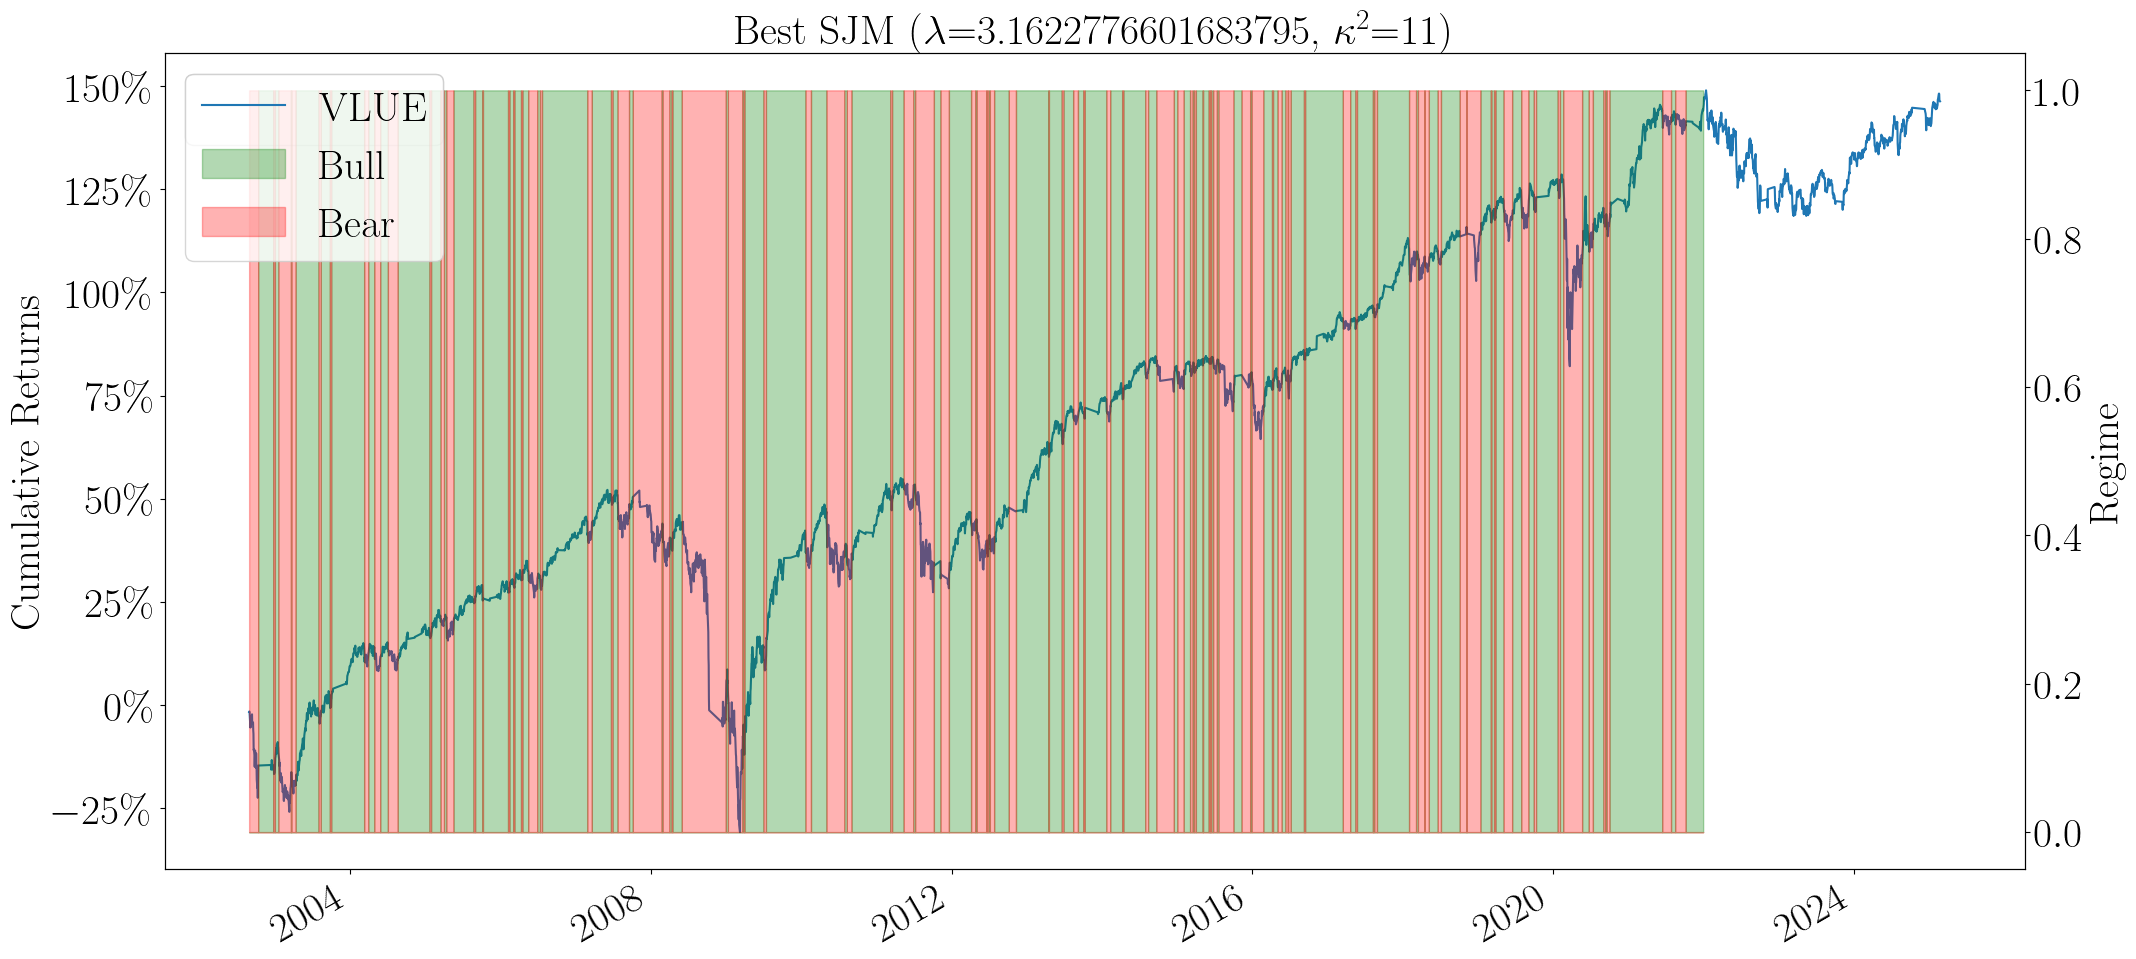

In [7]:
# **Predict and Plot Results**

# factor_data = pd.read_csv(factor_file, parse_dates=["Date"], index_col="Date")

predicted_states = best_model.predict(X_train_processed)

# print(predicted_states.head())
# print(factor_data["VLUE"].head())
# print(predicted_states.tail())
# print(factor_data["VLUE"].tail())

ax, ax2 = plot_regimes_and_cumret(predicted_states, data.ret_ser)
ax.set(title=f"Best SJM ($\\lambda$={best_lambda}, $\\kappa^2$={max_feats_best})")
plt.show()

In [8]:
# Predict the states on the in-sample data
print("Predicted states (in-sample):")
print(predicted_states)

# Print the feature weights (sparse weights)
print("SJM Feature Weights:")
print(best_model.feat_weights)

Predicted states (in-sample):
Date
2002-08-28    1
2002-08-29    1
2002-08-30    1
2002-09-03    1
2002-09-04    1
             ..
2021-12-27    0
2021-12-28    0
2021-12-29    0
2021-12-30    0
2021-12-31    0
Length: 3988, dtype: int64
SJM Feature Weights:
ActiveReturn_EWMA_8         0.334136
ActiveReturn_EWMA_21        0.373670
ActiveReturn_EWMA_63        0.324475
RSI_8                       0.486538
RSI_21                      0.614505
RSI_63                      0.547198
StochOsc_%K_8               0.395430
StochOsc_%K_21              0.639473
StochOsc_%K_63              0.709045
MACD_8_21                   0.440752
MACD_21_63                  0.204799
DownsideDev_log_21          0.189781
ActiveMarketBeta_EWMA_21    0.036406
MarketReturn_EWMA_21        0.579006
VIX_log_diff_EWMA_21        0.505843
2Y_diff_EWMA_21             0.272143
10Y-2Y_EWMA_21              0.099972
dtype: float64


In [9]:
# # check constraints

# w = best_model.feat_weights ** 2
# l1 = w.sum()
# l2 = np.sqrt((w**2).sum())

# print("L1 norm =", l1)
# print("L2 norm =", l2)
# print("Expected L1 (≈ kappa):", np.sqrt(best_model.max_feats))

w_internals = best_model.w  # The internal lasso vector

l1_w = w_internals.sum()
l2_w = np.sqrt((w_internals**2).sum())

print("L1 norm of w_internals =", l1_w)
print("L2 norm of w_internals =", l2_w)
print("Expected L1 (≈ kappa) =", np.sqrt(best_model.max_feats))

L1 norm of w_internals = 3.2870863995430275
L2 norm of w_internals = 1.0
Expected L1 (≈ kappa) = 3.3166247903554


In [10]:
# print("\n\n".join(In[i] for i in range(1, len(In))))
# check constraints


In [ ]:
#jupyter nbconvert --to script sparseJM_sharpe_crossval_v2.ipynb

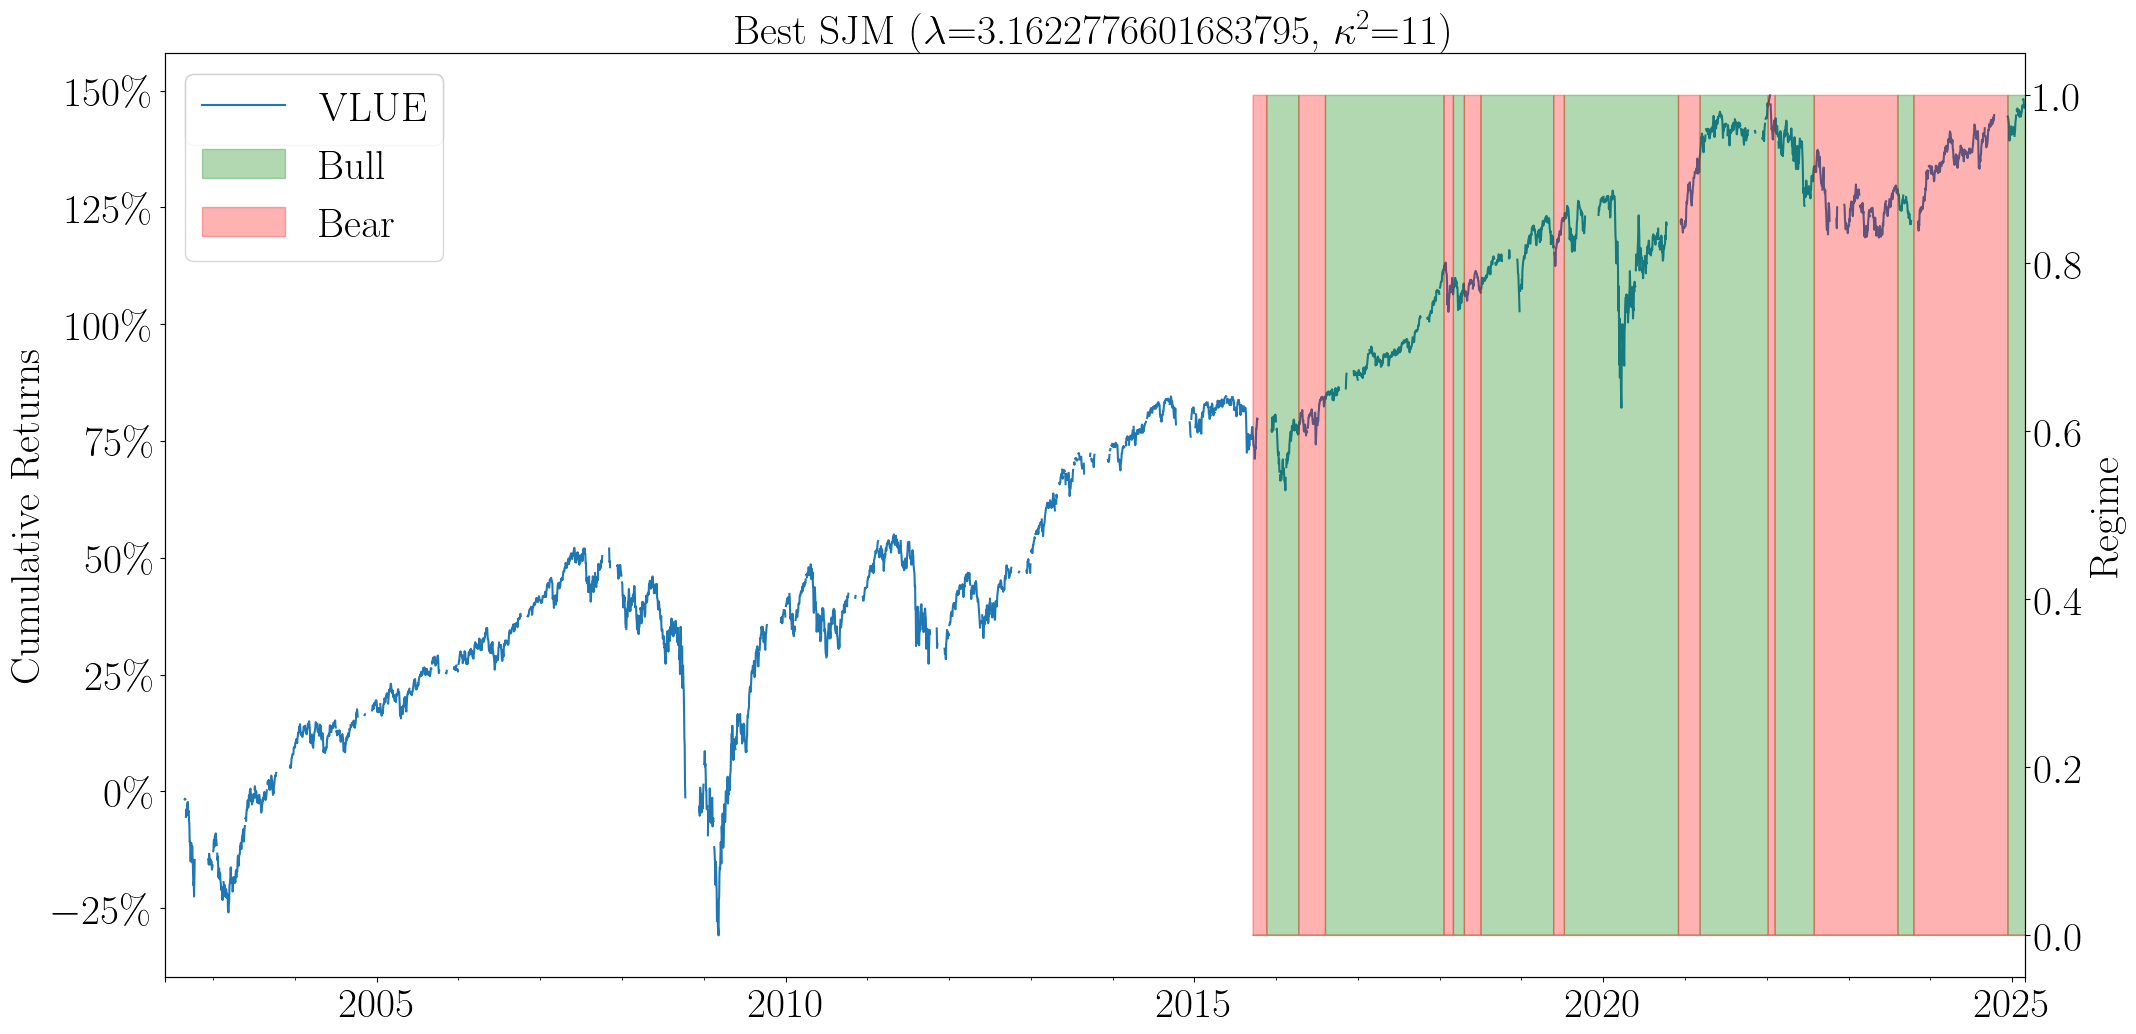

In [29]:
# **Final Model Training with Best (λ, κ) Values**
best_model = SparseJumpModel(n_components=2, max_feats=9.5, jump_penalty=50, cont=False, max_iter=30)
best_model.fit(X_train_processed, data.ret_ser, sort_by="cumret")

predicted_states = best_model.predict(X_train_processed)

# print(predicted_states.head())
# print(factor_data["VLUE"].head())
# print(predicted_states.tail())
# print(factor_data["VLUE"].tail())

ax, ax2 = plot_regimes_and_cumret(predicted_states, data.ret_ser)
ax.set(title=f"Best SJM ($\\lambda$={best_lambda}, $\\kappa^2$={max_feats_best})")
plt.show()

In [30]:
print(predicted_states)

Date
2002-08-28    1
2002-08-29    1
2002-08-30    1
2002-09-03    1
2002-09-04    1
             ..
2021-12-27    0
2021-12-28    0
2021-12-29    0
2021-12-30    0
2021-12-31    0
Length: 3988, dtype: int64
